In [97]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler

In [56]:
mat=U(1,1,1)
uni = mat.conj().T@mat
np.allclose(np.eye(4),uni,atol=1e-15)

True

In [ ]:
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

In [ ]:
#sqrt(iSWAP)
sqiswap = np.array( [
    [1, 0, 0, 0],
    [0, 1/np.sqrt(2), 1j/np.sqrt(2), 0],
    [0, 1j/np.sqrt(2), 1/np.sqrt(2), 0],
    [0, 0, 0, 1] ])

In [116]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b58a80862cd6d4e3f8618d0fb10c85a7415315bcf55dd407e498ce33bdd4709623e266b4fdee952700733135cd2fa847c7bffa65966a4efb0aa2ae6a4ad7b583", overwrite=True)

In [128]:
#EXECUTION PARAMETERS
n,A,T,G,step,layers=4,1,1,1,10,1
j=3

In [129]:
#OTOC
#PLUS PART



matrix = U(A,T/step,G)
qcp=QuantumCircuit(n)
#init
string = "0" * n
QuantumCircuit.initialize(qcp,'0111')
#V_i perturbation +pi/2
qcp.ry((np.pi/2),0,label='V_plus')
#fwd evolution
qcp.barrier(range(n))
qcp.barrier(range(n))
bwassembler(qcp,matrix,layers,n)
#W_j perturbation
qcp.z(j)
#backwards evolution
qcp.barrier(range(n))
qcp.barrier(range(n))
revbwassembler(qcp,matrix,layers,n)
#measurement 
op=generate_pauli(n,0)
basis_gates=['cx', 'id', 'rz', 'x', 'sx']
trans_plus=transpile(qcp, basis_gates=basis_gates, optimization_level=3)
#qcp.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')


In [130]:
#OTOC
#MINUS PART



matrix = U(A,T/step,G)
qcp=QuantumCircuit(n)
#init
string = "0" * n
QuantumCircuit.initialize(qcp,'0111')
#V_i perturbation -pi/2
qcp.ry((-np.pi/2),0,label='V_minus')
#fwd evolution
qcp.barrier(range(n))
qcp.barrier(range(n))
bwassembler(qcp,matrix,layers,n)
#W_j perturbation
qcp.z(j)
#backwards evolution
qcp.barrier(range(n))
qcp.barrier(range(n))
revbwassembler(qcp,matrix,layers,n)
#measurement 
op=generate_pauli(n,0)
basis_gates=['cx', 'id', 'rz', 'x', 'sx']
trans_minus=transpile(qcp, basis_gates=basis_gates, optimization_level=3)
#qcp.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')


In [131]:
#RUNTIME


#specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")



#settings job execution
service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 1000
options.optimization_level = 2  # optimization
options.resilience_level = 2  # mitigation


#runtime plus
with Session(service=service, backend=backend) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=[trans_plus], observables=[op])
    values_plus = job_sim.result().values
#runtime minus
with Session(service=service, backend=backend) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=[trans_minus], observables=[op])
    values_minus = job_sim.result().values

In [132]:
#DATA PROCESSING


C=2+values_minus-values_plus

print(values_plus, values_minus,C)

[-0.5235] [-0.53966667] [1.98383333]


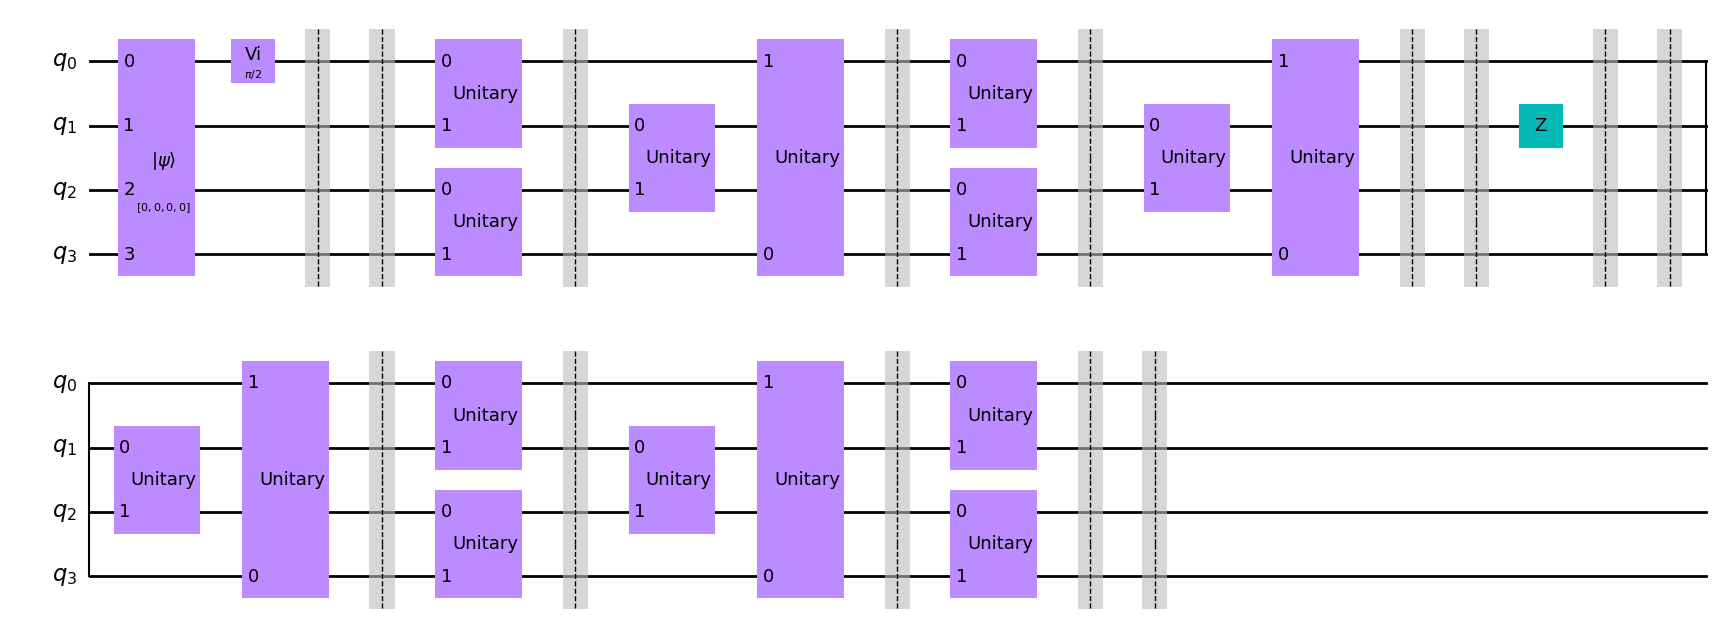

In [76]:
qcp.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

In [ ]:
#saving data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(n)+' init: '+str(string), 'wb') as file:
      
    # A new file will be created
    pickle.dump(ent_entropy, file)

In [ ]:
#loading data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n=10', 'rb') as file:
    loaded_data = pickle.load(file)

In [81]:
#define unitary
def U(A,T,G):
    U = np.zeros((4,4), dtype=complex)
    
    U[0,0]=(-1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[0,3]=(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,1]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,2]=(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,1]=(-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,2]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,0]=-(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,3]=(1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    return(U)

def bwassembler(qc,matrix,layers,n):
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n))
        
        
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(matrix,[2*j+1,0])
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        
        m+=1
    qc.barrier(range(n))
    return(qc)

def revbwassembler(qc,matrix,layers,n):
    matrix=matrix.conj().T
    m=0
    while m < layers:
        i=0;j=0;    
        
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(matrix,[2*j+1,0])
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n))
        
        
        m+=1
    qc.barrier(range(n))
    return(qc)


def generate_pauli(n, j):
    if n <= 0 or j < 0 or  j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "Z"
    pauli_str = "".join(pauli_str_list)
    op = SparsePauliOp(pauli_str, coeffs=[1])
    
    

    return op